# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [182]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib tk

import check_test
from plot_utils import plot_values

#
from tqdm import trange

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

/media/cat/4TBSSD/anaconda3/envs/rl/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/media/cat/4TBSSD/anaconda3/envs/rl/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [18]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

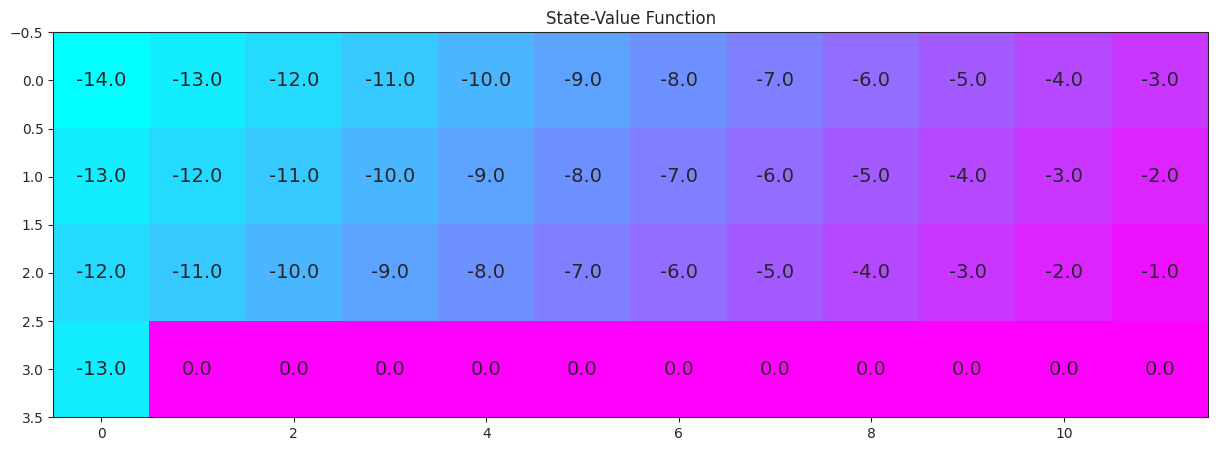

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [265]:
def plot_Q_sarsa(Q_sarsa):
    print (env.nA)

    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

    dirs = [
        [0,1],
        [1,0],
        [0,-1],
        [-1,0]
    ]

    #
    locs = np.zeros((48,2))
    locs[:,0] = np.arange(48)%12
    locs[:,1] = -np.int32(np.arange(48)/12)+3
    # for k in range(locs.shape[0]):
    #     print (k, locs[k])

    #
    plt.figure(figsize=(10,3))
    print (len(Q_sarsa))
    for k in range(len(Q_sarsa)):
        temp = np.argmax(Q_sarsa[k])
        #print (k,Q_sarsa[k])

        x0 = locs[k,0]
        y0 = locs[k,1]
        x1 = dirs[temp][0]*0.4
        y1 = dirs[temp][1]*0.4

        plt.arrow(x0, y0, x1, y1, width = 0.15)

    plt.show()

#
def get_action_epsilon_greedy(Q, state_t0, epsilon):
    
    #
    probs = Q[state_t0]
    probs = probs+abs(np.min(probs))
   # print ("probs: ", probs)
    
    #
    if np.sum(probs)>0:
        action = np.random.choice(np.arange(4), p=probs/np.sum(probs))
    else:
        action = np.random.choice(np.arange(4))
    
    #
    #print ("Q based action: ", action)
    
    # 
    idx = np.random.rand()
    if idx<epsilon:
        return action
    
    # otherwise just select a random action
    action = np.random.choice(np.arange(4))
        
    # 
    return action

def update_epsilon(epsilon,
                   i_episode):
    
    #
    temp = 1-(1-epsilon)**i_episode
    
    return temp

def update_Q_sarsa(Q, 
                   state_t0, 
                   action_t0,
                   state_t1,
                   action_t1,
                   reward_t1,
                   alpha,
                   gamma):
    
    #
    term1 = Q[state_t0][action_t0] 

    #
    term2 = gamma*Q[state_t1][action_t1] - Q[state_t0][action_t0]
    
    #
    term3 = alpha*(reward_t1 + term2)

    #                   
    total = term1+term3

    #
    return total


def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    for k in range(48):
        Q[k] = [1.0,1.0,1.0,1.0]
    
    print ("Q: ", Q, env.nA)
    
    # initialize performance monitor
    epsilon = 0.75
    
    # epsilong scaling
    epsilon_scaling = 1.001
    
    ###################################
    ###################################
    ###################################
    
    # loop over episodes
    for i_episode in trange(1, num_episodes+1):

        #
        env.reset()

        #
        state_t0 = 36 
        
        # monitor progress
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # update error function epsilon
        epsilon_use = update_epsilon(epsilon,
                                     i_episode)
        
        #print ("epsilon: ", epsilon)
        # chose action A0 using epsilon greedy method
        #add epsilon greedy part here to scramble action selection
        action_t0 = get_action_epsilon_greedy(Q, 
                                              state_t0,
                                              epsilon_use)
        
        
        # loop over all actions until reaching terminal state
        # set t<- 0
        t=0
        while True:
            
            # take action At and observe Rt+1 and St+1
            res = env.step(action_t0)    
            state_t1 = res[0]
            reward_t1 = res[1]
            terminal_flag = res[2]
        
            # chose action at At+1 using epsilon greedy policy from Q
            action_t1 = get_action_epsilon_greedy(Q, 
                                                  state_t1,
                                                  epsilon_use)

        
            # update policy; can alsu use separate function

            
            #
            Q[state_t0][action_t0] = update_Q_sarsa(Q, 
                                                   state_t0, 
                                                   action_t0,
                                                   state_t1,
                                                   action_t1,
                                                   reward_t1,
                                                   alpha,
                                                   gamma)
        
            
            #
            state_t0 = state_t1
            action_t0 = action_t1
              
            # check if St is terminal and break
            if terminal_flag==True:
                #print ("exit found")
                break
        
        
    return Q

In [266]:
#############################################
#############################################
#############################################
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

#
Q_sarsa = sarsa(env, 5000, .01)

#
plot_Q_sarsa(Q_sarsa)



Q:  defaultdict(<function sarsa.<locals>.<lambda> at 0x7f9ae0ed3c10>, {0: [1.0, 1.0, 1.0, 1.0], 1: [1.0, 1.0, 1.0, 1.0], 2: [1.0, 1.0, 1.0, 1.0], 3: [1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0], 5: [1.0, 1.0, 1.0, 1.0], 6: [1.0, 1.0, 1.0, 1.0], 7: [1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0], 9: [1.0, 1.0, 1.0, 1.0], 10: [1.0, 1.0, 1.0, 1.0], 11: [1.0, 1.0, 1.0, 1.0], 12: [1.0, 1.0, 1.0, 1.0], 13: [1.0, 1.0, 1.0, 1.0], 14: [1.0, 1.0, 1.0, 1.0], 15: [1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0], 17: [1.0, 1.0, 1.0, 1.0], 18: [1.0, 1.0, 1.0, 1.0], 19: [1.0, 1.0, 1.0, 1.0], 20: [1.0, 1.0, 1.0, 1.0], 21: [1.0, 1.0, 1.0, 1.0], 22: [1.0, 1.0, 1.0, 1.0], 23: [1.0, 1.0, 1.0, 1.0], 24: [1.0, 1.0, 1.0, 1.0], 25: [1.0, 1.0, 1.0, 1.0], 26: [1.0, 1.0, 1.0, 1.0], 27: [1.0, 1.0, 1.0, 1.0], 28: [1.0, 1.0, 1.0, 1.0], 29: [1.0, 1.0, 1.0, 1.0], 30: [1.0, 1.0, 1.0, 1.0], 31: [1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0], 33: [1.0, 1.0, 1.0, 1.0], 34: [1.0, 1.0, 1.0, 1.0], 35: [1.0, 1.0, 1.0, 1.0], 36:

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 166.85it/s]


4
48


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [267]:
# obtain the estimated optimal policy and corresponding action-value function
#Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
print (policy_sarsa)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

[[1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [269]:
def update_q_learning(Q, 
                   state_t0, 
                   action_t0,
                   state_t1,
                   action_t1,
                   reward_t1,
                   alpha,
                   gamma):
    
    #
    term1 = Q[state_t0][action_t0] 

    # here select the most likely action , rather than action t1
    # not super clear if we have to run this through epsilon-greedy discounter
    action_t1_new = np.argmax(Q[state_t1])      # is this really the correct or is it the next 
    
    
    # same as sarsa, but the action is the optimal one that would be taken
    term2 = gamma*Q[state_t1][action_t1_new] - Q[state_t0][action_t0]
    
    #
    term3 = alpha*(reward_t1 + term2)

    #                   
    total = term1+term3

    #
    return total


def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
   
    #
    for k in range(48):
        Q[k] = [1.0,1.0,1.0,1.0]
    
    print ("Q: ", Q, env.nA)
    
    # initialize performance monitor
    epsilon = 0.75
    
    # epsilong scaling
    epsilon_scaling = 1.001
    
    ###################################
    ###################################
    ###################################
    
    # loop over episodes
    for i_episode in trange(1, num_episodes+1):

        #
        env.reset()

        #
        state_t0 = 36 
        
        # monitor progress
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # update error function epsilon
        epsilon_use = update_epsilon(epsilon,
                                     i_episode)
        
        #print ("epsilon: ", epsilon)
        # chose action A0 using epsilon greedy method
        #add epsilon greedy part here to scramble action selection
        action_t0 = get_action_epsilon_greedy(Q, 
                                              state_t0,
                                              epsilon_use)
        
        
        # loop over all actions until reaching terminal state
        # set t<- 0
        t=0
        while True:
            
            # take action At and observe Rt+1 and St+1
            res = env.step(action_t0)    
            state_t1 = res[0]
            reward_t1 = res[1]
            terminal_flag = res[2]
        
            # chose action at At+1 using epsilon greedy policy from Q
            action_t1 = get_action_epsilon_greedy(Q, 
                                                  state_t1,
                                                  epsilon_use)

        
            # update policy; can alsu use separate function

            
            #
            Q[state_t0][action_t0] = update_q_learning(Q, 
                                                       state_t0, 
                                                       action_t0,
                                                       state_t1,
                                                       action_t1,
                                                       reward_t1,
                                                       alpha,
                                                       gamma)
        
            
            #
            state_t0 = state_t1
            action_t0 = action_t1
              
            # check if St is terminal and break
            if terminal_flag==True:
                #print ("exit found")
                break
        
        
        
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [270]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

Q:  defaultdict(<function q_learning.<locals>.<lambda> at 0x7f9ad2c71ee0>, {0: [1.0, 1.0, 1.0, 1.0], 1: [1.0, 1.0, 1.0, 1.0], 2: [1.0, 1.0, 1.0, 1.0], 3: [1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0], 5: [1.0, 1.0, 1.0, 1.0], 6: [1.0, 1.0, 1.0, 1.0], 7: [1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0], 9: [1.0, 1.0, 1.0, 1.0], 10: [1.0, 1.0, 1.0, 1.0], 11: [1.0, 1.0, 1.0, 1.0], 12: [1.0, 1.0, 1.0, 1.0], 13: [1.0, 1.0, 1.0, 1.0], 14: [1.0, 1.0, 1.0, 1.0], 15: [1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0], 17: [1.0, 1.0, 1.0, 1.0], 18: [1.0, 1.0, 1.0, 1.0], 19: [1.0, 1.0, 1.0, 1.0], 20: [1.0, 1.0, 1.0, 1.0], 21: [1.0, 1.0, 1.0, 1.0], 22: [1.0, 1.0, 1.0, 1.0], 23: [1.0, 1.0, 1.0, 1.0], 24: [1.0, 1.0, 1.0, 1.0], 25: [1.0, 1.0, 1.0, 1.0], 26: [1.0, 1.0, 1.0, 1.0], 27: [1.0, 1.0, 1.0, 1.0], 28: [1.0, 1.0, 1.0, 1.0], 29: [1.0, 1.0, 1.0, 1.0], 30: [1.0, 1.0, 1.0, 1.0], 31: [1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0], 33: [1.0, 1.0, 1.0, 1.0], 34: [1.0, 1.0, 1.0, 1.0], 35: [1.0, 1.0, 1.0, 1.0]

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 150.18it/s]


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[0 1 1 1 1 1 1 1 1 1 2 2]
 [0 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [280]:
#
def compute_expected_val(Q,
                         state_t1):
    
    # grab probs and normalize so they start at zero; and also sum up to 1
    probs = Q[state_t1]
    probs = (probs-np.min(probs))
    
    #
    if np.sum(probs)==0:
        probs = np.zeros(4)*0.25
    else:
        probs = probs/np.sum(probs)
        
   # print ("probs: ", probs)
   # print ("Q vals: ", Q[state_t1])
    
    #
    total_val = 0
    for k in range(4):
        prob = probs[k]
        val = Q[state_t1][k]
        
        total_val += prob*val
        
  #  print ("total val: ", total_val)
 #   print ('')
    return total_val
    
#
def update_expected_sarsa(Q, 
                   state_t0, 
                   action_t0,
                   state_t1,
                   action_t1,
                   reward_t1,
                   alpha,
                   gamma):
    
    #
    term1 = Q[state_t0][action_t0] 

    # here select the most likely action , rather than action t1
    # not super clear if we have to run this through epsilon-greedy discounter
    expected_val = compute_expected_val(Q, 
                                        state_t1)      # is this really the correct or is it the next 
    
    
    # same as sarsa, but the action is the optimal one that would be taken
    term2 = gamma*expected_val - Q[state_t0][action_t0]
    
    #
    term3 = alpha*(reward_t1 + term2)

    #                   
    total = term1+term3

    #
    return total


def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    #
    for k in range(48):
        Q[k] = [1.0,1.0,1.0,1.0]
    
    print ("Q: ", Q, env.nA)
    
    # initialize performance monitor
    epsilon = 0.75
    
    # epsilong scaling
    epsilon_scaling = 1.001
    
    ###################################
    ###################################
    ###################################
    
    # loop over episodes
    for i_episode in trange(1, num_episodes+1):

        #
        env.reset()

        #
        state_t0 = 36 
        
        # monitor progress
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # update error function epsilon
        epsilon_use = update_epsilon(epsilon,
                                     i_episode)
        
        #print ("epsilon: ", epsilon)
        # chose action A0 using epsilon greedy method
        #add epsilon greedy part here to scramble action selection
        action_t0 = get_action_epsilon_greedy(Q, 
                                              state_t0,
                                              epsilon_use)
        
        
        # loop over all actions until reaching terminal state
        # set t<- 0
        t=0
        while True:
            
            # take action At and observe Rt+1 and St+1
            res = env.step(action_t0)    
            state_t1 = res[0]
            reward_t1 = res[1]
            terminal_flag = res[2]
        
            # chose action at At+1 using epsilon greedy policy from Q
            action_t1 = get_action_epsilon_greedy(Q, 
                                                  state_t1,
                                                  epsilon_use)

        
            # update policy; can alsu use separate function

            
            #
            Q[state_t0][action_t0] = update_expected_sarsa(Q, 
                                                       state_t0, 
                                                       action_t0,
                                                       state_t1,
                                                       action_t1,
                                                       reward_t1,
                                                       alpha,
                                                       gamma)
        
            
            #
            state_t0 = state_t1
            action_t0 = action_t1
              
            # check if St is terminal and break
            if terminal_flag==True:
                #print ("exit found")
                break
        
        
        
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [282]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, .01)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

Q:  defaultdict(<function expected_sarsa.<locals>.<lambda> at 0x7f9ad35fe940>, {0: [1.0, 1.0, 1.0, 1.0], 1: [1.0, 1.0, 1.0, 1.0], 2: [1.0, 1.0, 1.0, 1.0], 3: [1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0], 5: [1.0, 1.0, 1.0, 1.0], 6: [1.0, 1.0, 1.0, 1.0], 7: [1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0], 9: [1.0, 1.0, 1.0, 1.0], 10: [1.0, 1.0, 1.0, 1.0], 11: [1.0, 1.0, 1.0, 1.0], 12: [1.0, 1.0, 1.0, 1.0], 13: [1.0, 1.0, 1.0, 1.0], 14: [1.0, 1.0, 1.0, 1.0], 15: [1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0], 17: [1.0, 1.0, 1.0, 1.0], 18: [1.0, 1.0, 1.0, 1.0], 19: [1.0, 1.0, 1.0, 1.0], 20: [1.0, 1.0, 1.0, 1.0], 21: [1.0, 1.0, 1.0, 1.0], 22: [1.0, 1.0, 1.0, 1.0], 23: [1.0, 1.0, 1.0, 1.0], 24: [1.0, 1.0, 1.0, 1.0], 25: [1.0, 1.0, 1.0, 1.0], 26: [1.0, 1.0, 1.0, 1.0], 27: [1.0, 1.0, 1.0, 1.0], 28: [1.0, 1.0, 1.0, 1.0], 29: [1.0, 1.0, 1.0, 1.0], 30: [1.0, 1.0, 1.0, 1.0], 31: [1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0], 33: [1.0, 1.0, 1.0, 1.0], 34: [1.0, 1.0, 1.0, 1.0], 35: [1.0, 1.0, 1.0, 

100%|████████████████████████████████████████████████████████████████████▊| 9979/10000 [01:03<00:00, 275.63it/s]

Episode 10000/10000

100%|████████████████████████████████████████████████████████████████████| 10000/10000 [01:03<00:00, 158.50it/s]


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[2 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
